In [3]:

!pip install xgboost
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.6 MB/s eta 0:00:00


In [4]:
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00


✅ Data Preprocessing Started...


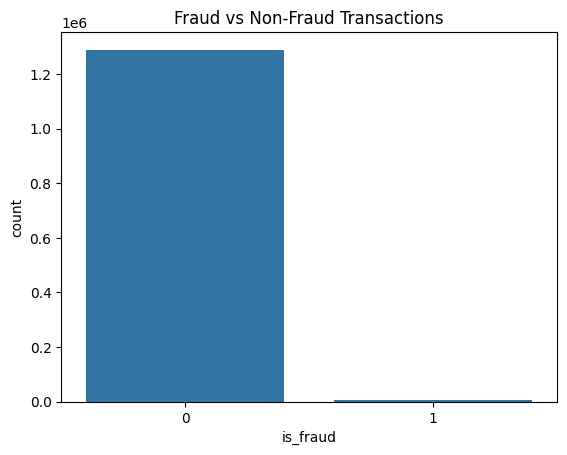

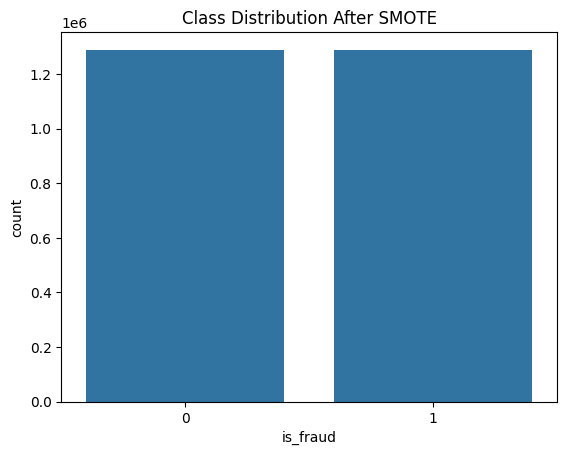

✅ Training Models...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest Performance:
Accuracy: 0.9981
Precision: 0.9970
Recall: 0.9993
F1 Score: 0.9981
Confusion Matrix:
 [[256397    789]
 [   180 258302]]

XGBoost Performance:
Accuracy: 0.9855
Precision: 0.9875
Recall: 0.9835
F1 Score: 0.9855
Confusion Matrix:
 [[253978   3208]
 [  4276 254206]]


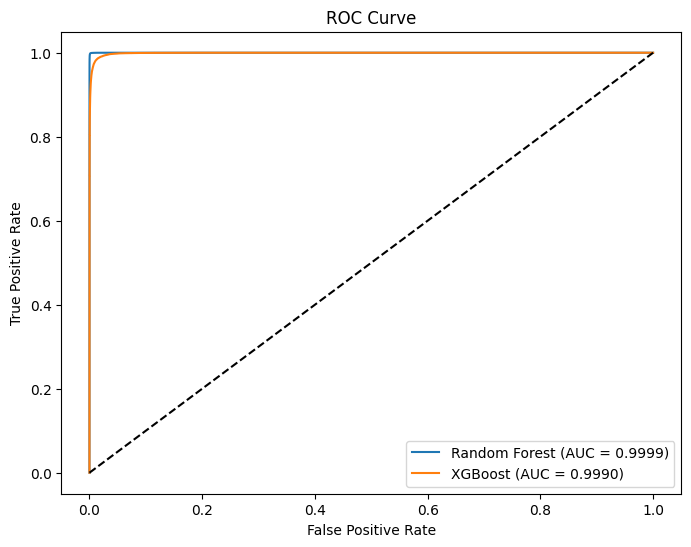

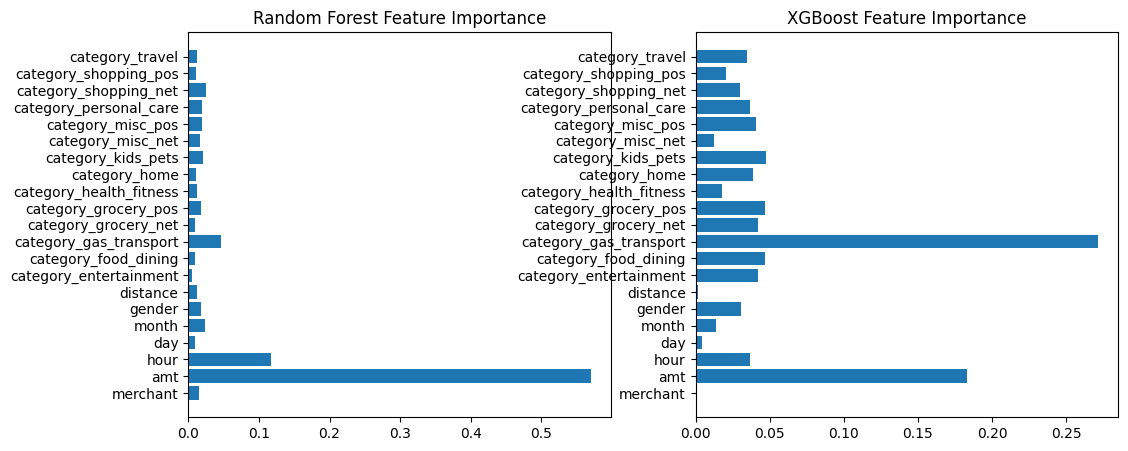

✅ Models and encoders saved successfully!


In [5]:
import pandas as pd
import numpy as np
import joblib
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Step 1: Load dataset
df = pd.read_csv(r"/content/drive/MyDrive/dataset.csv")

# Step 2: Data Preprocessing
print("✅ Data Preprocessing Started...")

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

# Drop unnecessary columns
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num']
df = df.drop(columns=drop_columns)

# Encode categorical variables
label_encoders = {}
for col in ['merchant', 'gender']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-Hot Encoding for 'category'
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
category_encoded = onehot_encoder.fit_transform(df[['category']])
category_columns = onehot_encoder.get_feature_names_out(['category'])
df = df.drop(columns=['category']).join(pd.DataFrame(category_encoded, columns=category_columns))

# Calculate geodesic distance
df['distance'] = np.array([geodesic((a, b), (c, d)).km for a, b, c, d in zip(df['lat'], df['long'], df['merch_lat'], df['merch_long'])])

# Define features and target
features = ['merchant', 'amt', 'hour', 'day', 'month', 'gender', 'distance'] + list(category_columns)
X = df[features]
y = df['is_fraud']

# Class distribution visualization
sns.countplot(x=y)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

# Step 3: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize class distribution after SMOTE
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Train Models
print("✅ Training Models...")

# Train Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time

# Train XGBoost
start_time = time.time()
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time

# Step 6: Evaluate Models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return y_pred

rf_preds = evaluate_model("Random Forest", rf_model, X_test, y_test)
xgb_preds = evaluate_model("XGBoost", xgb_model, X_test, y_test)

# Step 7: ROC Curve Visualization
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(8,6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {auc(rf_fpr, rf_tpr):.4f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {auc(xgb_fpr, xgb_tpr):.4f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Step 8: Feature Importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.barh(features, rf_model.feature_importances_)
plt.title("Random Forest Feature Importance")

plt.subplot(1, 2, 2)
plt.barh(features, xgb_model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

# Step 9: Save Models
joblib.dump(rf_model, "random_forest_model1.pkl")
joblib.dump(xgb_model, "xgboost_model1.pkl")
joblib.dump(label_encoders, "label_encoders1.pkl")
joblib.dump(onehot_encoder, "onehot_encoder1.pkl")
joblib.dump(features, "feature_order1.pkl")

print("✅ Models and encoders saved successfully!")